In [3]:
!nvidia-smi

Sun Oct  2 10:45:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:00:06.0 Off |                  Off |
| N/A   31C    P0    39W / 250W |      0MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pathlib
import matplotlib.pyplot as plt
import pydot
from keras.utils.vis_utils import plot_model
from tensorflow.keras.applications.vgg16 import VGG16    

In [5]:
vmodel = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
print(vmodel.summary())

2022-10-02 10:49:13.696102: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-02 10:49:14.465811: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30985 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:00:06.0, compute capability: 7.0


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [19]:
data_dir = './static/img/train'

# Hyper Parameters
img_height = 224
img_width = 224
batch_size = 64
epochs = 20

In [7]:
# trainning data load
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 119,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 844 files belonging to 208 classes.
Using 676 files for training.


In [8]:
# validation data load
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 844 files belonging to 208 classes.
Using 168 files for validation.


In [9]:
# check label(class) loaded
class_names = train_ds.class_names
print(class_names)

['10001', '10002', '10003', '10004', '10005', '10006', '10007', '10008', '10009', '10010', '10011', '10012', '10013', '10014', '10015', '10016', '10017', '10018', '10019', '10020', '10021', '10022', '10023', '10024', '10025', '10026', '10027', '10028', '10029', '10030', '10031', '10032', '10033', '10034', '10035', '10036', '10037', '10038', '10039', '10040', '10041', '10042', '10043', '10044', '10045', '10046', '10047', '10048', '10049', '10050', '10051', '10052', '10053', '10054', '10055', '10056', '10057', '10058', '10059', '10060', '10061', '10062', '10063', '10064', '10065', '10066', '10067', '10068', '10069', '10070', '10071', '10072', '10073', '10074', '10075', '10076', '10077', '10078', '10079', '10080', '10081', '10082', '10083', '10084', '10085', '10086', '10087', '10088', '10089', '10090', '10091', '10092', '10093', '10094', '10095', '10096', '10097', '10098', '10099', '10100', '10101', '10102', '10103', '10104', '10105', '10106', '10107', '10108', '10109', '10110', '10111', 

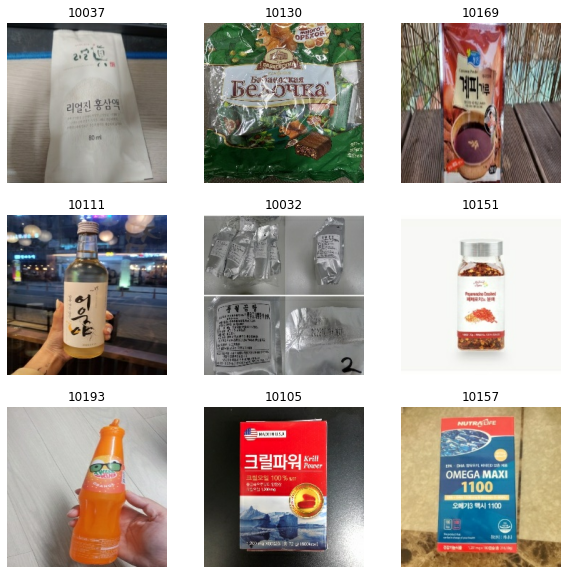

In [10]:
import matplotlib.pyplot as plt

# check image loaded
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [12]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

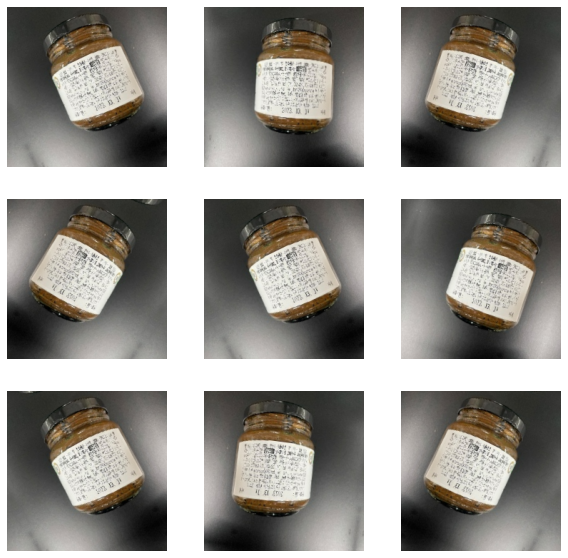

In [14]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [15]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [16]:
# check image size for input
for image_batch, labels_batch in augmented_train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(64, 224, 224, 3)
(64,)


In [17]:
img_shape = (img_height, img_width, 3)
vgg16_model = tf.keras.applications.VGG16(
    weights = 'imagenet',
    include_top = False,
    input_shape = img_shape
)
vgg16_model.trainable = False

In [18]:
# flatten 없음 -> globalaveragepooling 대체 (가중치 불필요)
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# FFNN
prediction_layer = tf.keras.layers.Dense(len(class_names), activation = 'softmax')

model_name = 'piwoodamodel.h5'

model = tf.keras.Sequential([
    vgg16_model,
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    global_average_layer,
    prediction_layer
])

"""
V0
model = tf.keras.Sequential([
    vgg16_model,
    global_average_layer,
    prediction_layer
])
V1
model = tf.keras.Sequential([
    vgg16_model,
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    global_average_layer,
    prediction_layer
])
V2
model = tf.keras.Sequential([
    vgg16_model,
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4096, activation='relu'),
    global_average_layer,
    prediction_layer
])
V3
model = tf.keras.Sequential([
    vgg16_model,
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    global_average_layer,
    prediction_layer
])
"""

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 7, 7, 512)         0         
                                                                 
 dense_1 (Dense)             (None, 7, 7, 4096)        2101248   
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 4096)        0         
                                                                 
 global_average_pooling2d (G  (None, 4096)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 208)               852176    
                                                      

In [20]:
# model trainning and save to file
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

history = model.fit(
    augmented_train_ds, 
    epochs = epochs,
    validation_steps = 2,
    validation_data = (val_ds)
)

model.save(model_name)

Epoch 1/20


2022-10-02 11:01:30.429596: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2022-10-02 11:01:31.065798: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.2.89, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


11/11 [==============================] - 14s 771ms/step - loss: 26.4607 - accuracy: 0.0178 - val_loss: 16.7110 - val_accuracy: 0.1484
Epoch 2/20
11/11 [==============================] - 6s 500ms/step - loss: 14.0507 - accuracy: 0.1169 - val_loss: 7.1067 - val_accuracy: 0.2344
Epoch 3/20
11/11 [==============================] - 6s 500ms/step - loss: 6.2786 - accuracy: 0.3299 - val_loss: 3.8726 - val_accuracy: 0.3750
Epoch 4/20
11/11 [==============================] - 6s 499ms/step - loss: 3.0729 - accuracy: 0.5133 - val_loss: 2.8625 - val_accuracy: 0.5703
Epoch 5/20
11/11 [==============================] - 6s 500ms/step - loss: 1.9289 - accuracy: 0.6908 - val_loss: 2.1322 - val_accuracy: 0.7266
Epoch 6/20
11/11 [==============================] - 6s 499ms/step - loss: 1.2090 - accuracy: 0.8328 - val_loss: 1.7961 - val_accuracy: 0.8125
Epoch 7/20
11/11 [==============================] - 6s 499ms/step - loss: 0.8124 - accuracy: 0.8787 - val_loss: 1.5759 - val_accuracy: 0.8203
Epoch 8/20
11

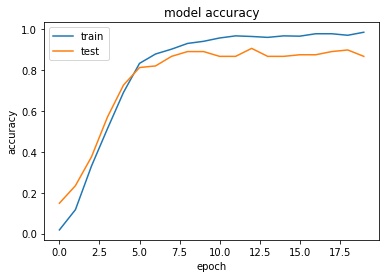

In [21]:
# show learning accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

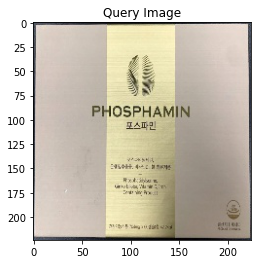

piwoodamodel.h5 result: 10001 - (주)RKM Tech 포스파민 (20.84%)


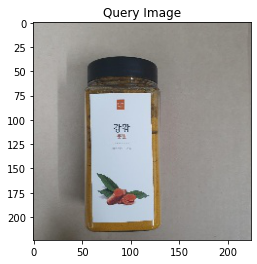

piwoodamodel.h5 result: 10005 - (주)바르미식품 강황가루 (64.74%)


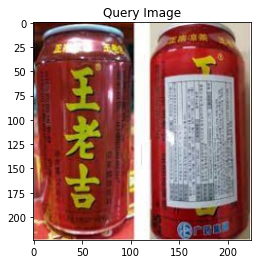

piwoodamodel.h5 result: 10007 - (주)성신푸드 왕로지 (99.45%)


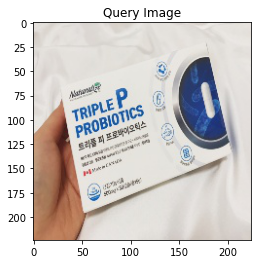

piwoodamodel.h5 result: 10144 - 주식회사비락 올바른우유클래식 (35.31%)


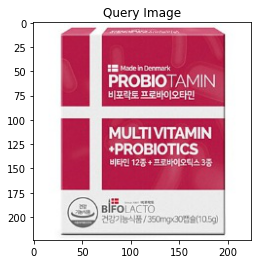

piwoodamodel.h5 result: 10026 - (주)파마택코리아 파마젠 유산균의 아침 더파이브V (28.26%)


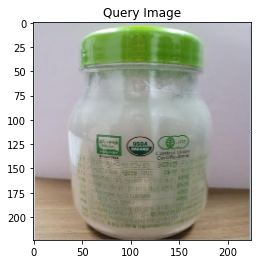

piwoodamodel.h5 result: 10019 - (주)제이엔제이트레이드(J&J Trade Co. Ltd.) 코코엘 오가닉 엑스트라 버진 코코넛오일 (99.32%)


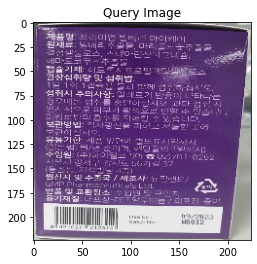

piwoodamodel.h5 result: 10026 - (주)파마택코리아 파마젠 유산균의 아침 더파이브V (48.64%)


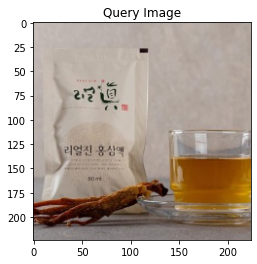

piwoodamodel.h5 result: 10037 - 금산인삼협동조합 리얼진홍삼액 (98.03%)


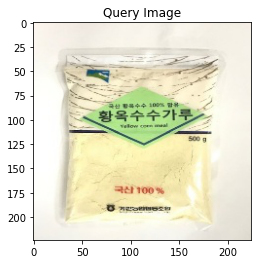

piwoodamodel.h5 result: 10039 - 기린농협가공사업소 황옥수수가루 (98.68%)


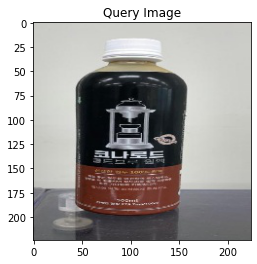

piwoodamodel.h5 result: 10042 - 남영상사 코나로드더치커피(커피의눈물) (87.23%)


In [22]:
# model test
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

product_names = []
data_frame = pd.read_csv('./static/foodsafety6.csv')
data_frame['label'] = data_frame['filename'] // 10000
df = data_frame.drop_duplicates(subset='label')
for row in df.itertuples():
    product_names.append([row[4], row[1]])


test_images = [
    './static/uploaded/100011002.jpg',
    './static/uploaded/100051001.jpg',
    './static/uploaded/100071003.jpg',
    './static/uploaded/100101004.jpg',
    './static/uploaded/100251003.jpg',
    './static/uploaded/100191002.jpg',
    './static/uploaded/100271002.jpg',
    './static/uploaded/100371008.jpg',
    './static/uploaded/100391006.jpg',
    './static/uploaded/100421001.jpg'
]

model_name = 'piwoodamodel.h5'
model = load_model(model_name)

img_height = 224
img_width = 224

for image_file in test_images:
    query_image = load_img(image_file, target_size = (img_height, img_width))

    np_image = img_to_array(query_image)
    plt.imshow(np.uint8(np_image))
    plt.title('Query Image')
    plt.show()
    #print("numpy array size: ", np_image.shape)
    image_batch = np.expand_dims(np_image, axis = 0)

    predict_vals = model.predict(image_batch)

    candidated = np.argmax(predict_vals)
    candidated_acc = predict_vals[0][candidated]
    print("%s result: %d - %s (%.2f%%)" % 
            (model_name, product_names[candidated][0], 
            product_names[candidated][1], candidated_acc * 100)
         )


In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 7, 7, 512)         0         
                                                                 
 dense_1 (Dense)             (None, 7, 7, 4096)        2101248   
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 4096)        0         
                                                                 
 global_average_pooling2d (G  (None, 4096)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 208)               852176    
                                                      